#ENV

In [1]:
import numpy as np
from scipy.stats import poisson

# Constants
MAX_CARS = 20
MAX_MOVE = 5
MOVE_COST = 2
RENT_REWARD = 10
DISCOUNT = 0.2

# Poisson lambda values
LAMBDA_REQUEST_1 = 3
LAMBDA_REQUEST_2 = 4
LAMBDA_RETURN_1 = 3
LAMBDA_RETURN_2 = 2

# Action Space: -5 (move from loc2 to loc1) to 5 (move from loc1 to loc2)
ACTIONS = np.arange(-MAX_MOVE, MAX_MOVE + 1)

In [2]:
def step(state, action):
    # Apply action: move cars
    cars_loc1, cars_loc2 = state
    cars_loc1 = min(cars_loc1 - action, MAX_CARS)  # if action is positive, cars are moved from loc1
    cars_loc2 = min(cars_loc2 + action, MAX_CARS)  # if action is positive, cars are moved to loc2

    # Calculate movement cost
    reward = -MOVE_COST * abs(action)

    # Rent cars
    rented_from_loc1 = min(cars_loc1, poisson.rvs(LAMBDA_REQUEST_1))
    rented_from_loc2 = min(cars_loc2, poisson.rvs(LAMBDA_REQUEST_2))

    reward += RENT_REWARD * (rented_from_loc1 + rented_from_loc2)

    # Update cars after rentals
    cars_loc1 -= rented_from_loc1
    cars_loc2 -= rented_from_loc2

    # Return cars
    cars_loc1 = min(cars_loc1 + poisson.rvs(LAMBDA_RETURN_1), MAX_CARS)
    cars_loc2 = min(cars_loc2 + poisson.rvs(LAMBDA_RETURN_2), MAX_CARS)

    return (cars_loc1, cars_loc2), reward

#POLICY

In [3]:
value_function = np.zeros((MAX_CARS + 1, MAX_CARS + 1)) + 150
test_buffer = value_function.copy()
policy = np.zeros((MAX_CARS + 1, MAX_CARS + 1), dtype=int)

In [4]:
from tqdm import tqdm

def policy_evaluation(threshold=10, samples=100):
    global policy, value_function  # Referencing global variables
    deltas = []  # To store deltas for the progress bar
    pbar = tqdm(total=threshold, desc="Policy Eval Delta", position=0)

    while True:
        delta = 0
        for i in range(MAX_CARS + 1):
            for j in range(MAX_CARS + 1):
                new_value = 0
                action = policy[i][j]
                # Loop to compute average over samples
                total_reward = 0
                total_value = 0
                for _ in range(samples):
                    (next_i, next_j), reward = step((i, j), action)
                    total_reward += reward
                    total_value += value_function[next_i][next_j]

                # Averaging over samples
                avg_reward = total_reward / samples
                avg_value = total_value / samples
                new_value = avg_reward + DISCOUNT * avg_value

                delta = max(delta, abs(value_function[i][j] - new_value))
                value_function[i][j] = new_value

        pbar.set_description(f"Policy Eval Delta: {delta:.5f}, Max Value: {np.max(value_function):.2f}")
        deltas.append(delta)
        pbar.n = delta  # Update the progress bar with the current delta
        pbar.last_print_n = delta
        pbar.refresh()
        if delta < threshold:
            break

    pbar.close()
    return value_function


In [5]:
def policy_improvement(num_samples=100):
    global policy, value_function  # Referencing global variables
    policy_stable = True
    state_changes = 0  # To count state changes
    pbar = tqdm(total=(MAX_CARS+1)**2, desc="Policy Improvement", position=0)

    for i in range(MAX_CARS + 1):
        for j in range(MAX_CARS + 1):
            old_action = policy[i][j]
            max_value = -float('inf')
            best_action = None

            for action in ACTIONS:
                total_value_for_action = 0
                for _ in range(num_samples):
                    (next_i, next_j), reward = step((i, j), action)
                    total_value_for_action += reward + DISCOUNT * value_function[next_i][next_j]

                avg_value_for_action = total_value_for_action / num_samples
                if avg_value_for_action > max_value:
                    max_value = avg_value_for_action
                    best_action = action

            policy[i][j] = best_action
            if old_action != best_action:
                policy_stable = False
                state_changes += 1
            pbar.update(1)  # Update progress bar

    pbar.close()
    print(f"Total States Changed: {state_changes}")
    return policy, policy_stable


In [6]:
import matplotlib.pyplot as plt

def policy_iteration():
    iterations = 0
    while iterations<5:
        policy_evaluation()  # Removing arguments
        policy, policy_stable = policy_improvement()  # Removing arguments
        iterations += 1
        if policy_stable:
            break

        fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the number of subplots and figure size

        # Plotting test_buffer with the 'viridis' colormap and adding a colorbar
        im0 = axes[0].imshow(test_buffer, cmap='viridis')
        axes[0].set_title("test_buffer")
        fig.colorbar(im0, ax=axes[0], shrink=0.6)

        # Plotting value_function with the 'plasma' colormap and adding a colorbar
        im1 = axes[1].imshow(value_function, cmap='plasma')
        axes[1].set_title("value_function")
        fig.colorbar(im1, ax=axes[1], shrink=0.6)

        # Plotting policy with the 'inferno' colormap and adding a colorbar
        im2 = axes[2].imshow(policy, cmap='inferno')
        axes[2].set_title("policy")
        fig.colorbar(im2, ax=axes[2], shrink=0.6)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

    return policy

Policy Eval Delta: 10.42188, Max Value: 93.87: : 11.214167788222952it [00:50,  4.49s/it]/usr/local/lib/python3.10/dist-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Policy Eval Delta: 9.97767, Max Value: 93.68: 100%|█████████▉| 9.977666446365888/10 [01:00<00:00,  6.11s/it]
Policy Improvement: 100%|██████████| 441/441 [01:56<00:00,  3.78it/s]


Total States Changed: 269


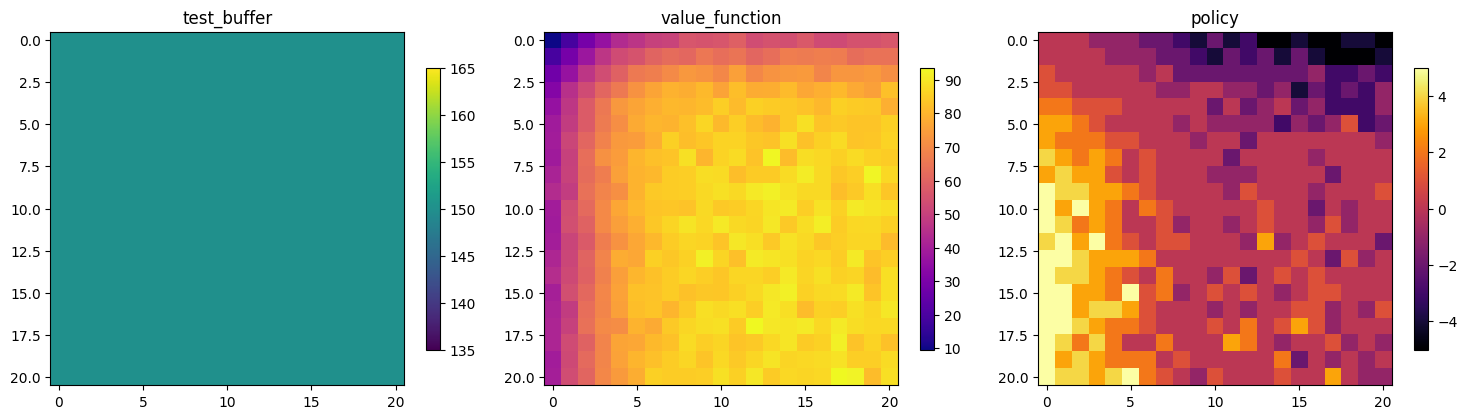

Policy Eval Delta: 9.50813, Max Value: 93.32:  95%|█████████▌| 9.508129677296779/10 [01:35<00:04, 10.06s/it]
Policy Improvement: 100%|██████████| 441/441 [01:57<00:00,  3.76it/s]


Total States Changed: 262


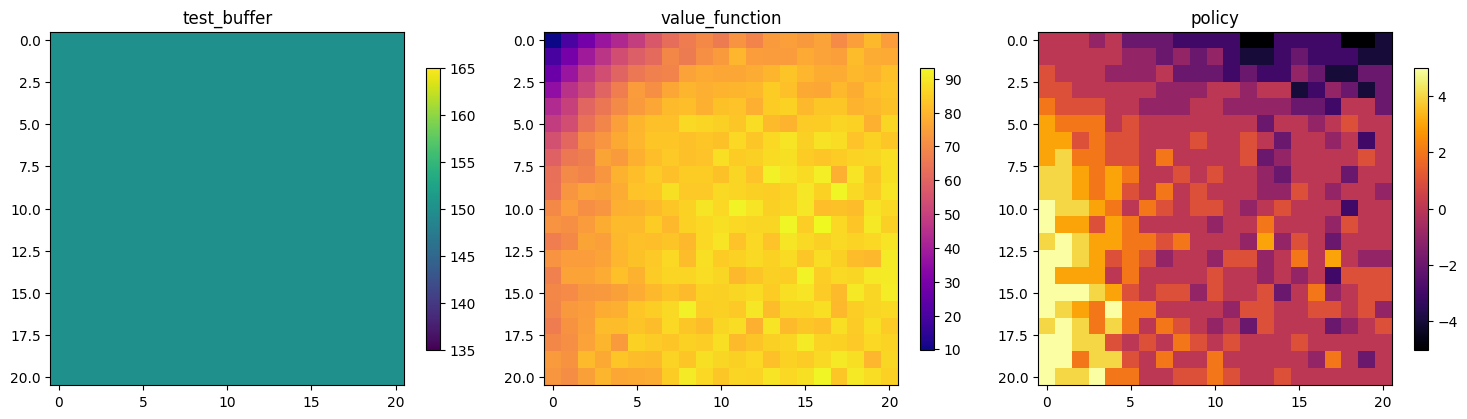

Policy Eval Delta: 9.12830, Max Value: 95.33:  91%|█████████▏| 9.128296624534954/10 [00:41<00:03,  4.56s/it]
Policy Improvement: 100%|██████████| 441/441 [02:02<00:00,  3.61it/s]


Total States Changed: 257


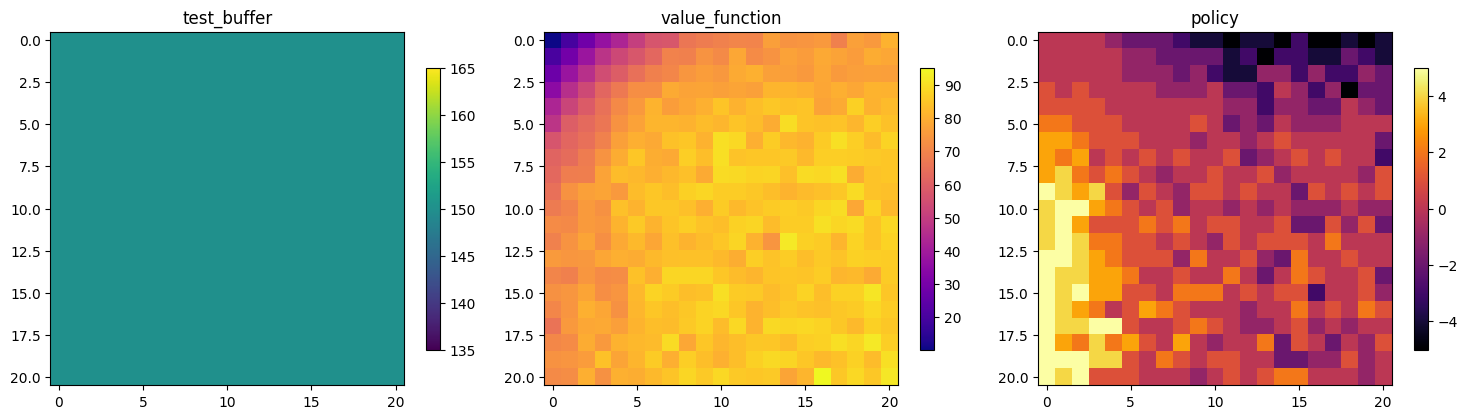

Policy Eval Delta: 9.90447, Max Value: 93.10:  99%|█████████▉| 9.904465685736099/10 [00:30<00:00,  3.05s/it]
Policy Improvement: 100%|██████████| 441/441 [01:57<00:00,  3.77it/s]


Total States Changed: 280


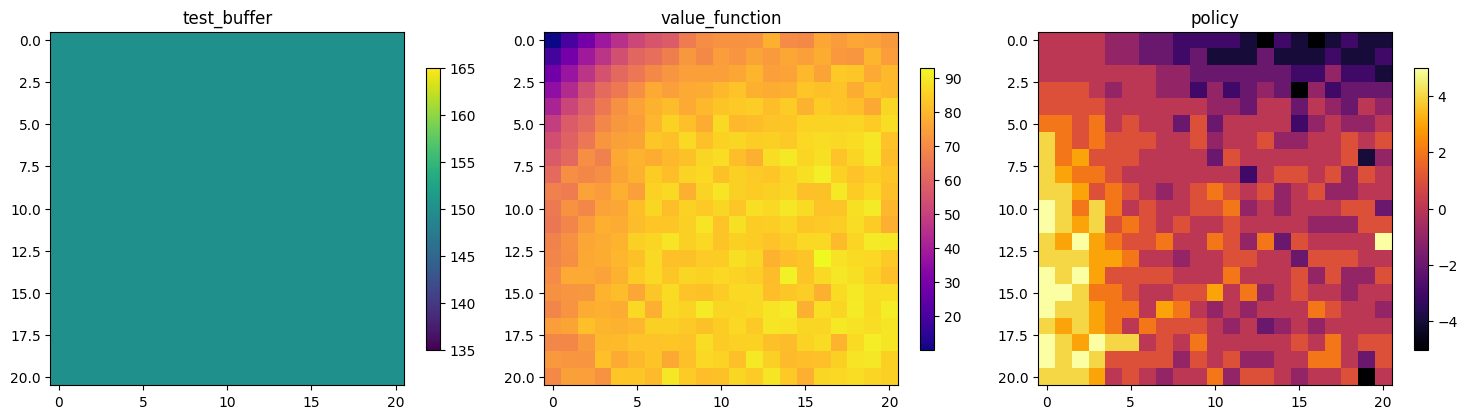

Policy Eval Delta: 8.97558, Max Value: 94.58:  90%|████████▉ | 8.975584632469946/10 [00:20<00:02,  2.32s/it]
Policy Improvement: 100%|██████████| 441/441 [01:56<00:00,  3.78it/s]


Total States Changed: 288


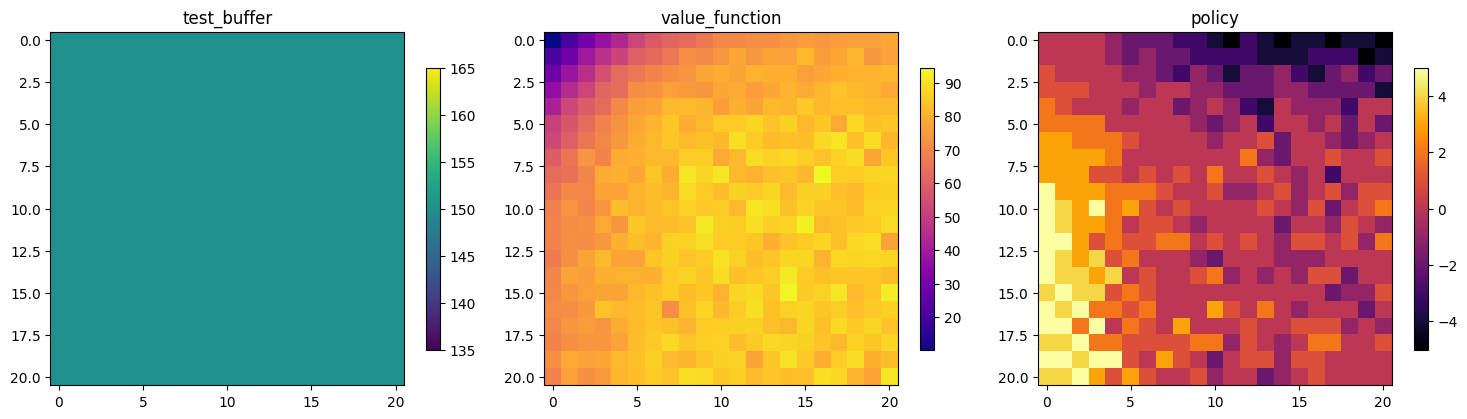

[[ 0  0  0  0 -1 -2 -2 -2 -3 -3 -4 -5 -3 -4 -5 -4 -4 -5 -4 -4 -5]
 [ 0  0  0  0 -1 -2 -1 -2 -2 -3 -3 -3 -3 -4 -4 -4 -3 -3 -3 -5 -4]
 [ 1  0  0  0  0 -1 -1 -2 -3 -1 -2 -4 -2 -2 -1 -3 -4 -2 -1 -3 -2]
 [ 1  1  1  0  0  0 -1  0  0 -1 -1 -2 -2 -2 -1 -1 -2 -2 -2 -2 -4]
 [ 2  1  0  0  0 -1  0  0 -2 -1  0 -1 -3 -4  0 -1 -1 -1 -3  0  0]
 [ 2  2  2  2  0  0  0  0  0 -1 -2 -1  0 -3  0  0 -1  0 -2  0 -2]
 [ 3  3  2  2  2  1  0  0  0  0 -1  0  0  1 -2  0  0 -1 -2 -1  0]
 [ 3  3  3  3  2  0  0  0  0  0  0  0  2 -1 -2  0  0  1  0  0  1]
 [ 3  3  3  1  1  0  1  0  1  0  2  0  0  1  0 -1  0 -3  0  0  0]
 [ 5  3  3  3  2  2  2  1  0  0  1 -1 -1  0  1 -1  0  1 -1  1  1]
 [ 5  4  3  5  2  3  1  0  1  0  0  0  0  1  0 -1  1 -2  0  1  2]
 [ 5  4  3  3  2  0  1  1  0 -1  0  0  0  0 -2  0  0 -1  1  0 -1]
 [ 5  5  3  1  2  1  1  2  2  0  1  0  1  0 -1  1  1  0  1 -1  2]
 [ 5  4  3  4  1  2  0  0  0 -1 -2  0  0  0 -1 -1 -1  0  0  0  0]
 [ 5  4  4  3  4  0  1  0  0  1  2 -1  0 -1  0 -1  1  1 -2  0  0]
 [ 4  5  4

In [7]:
final_policy = policy_iteration()
print(final_policy)

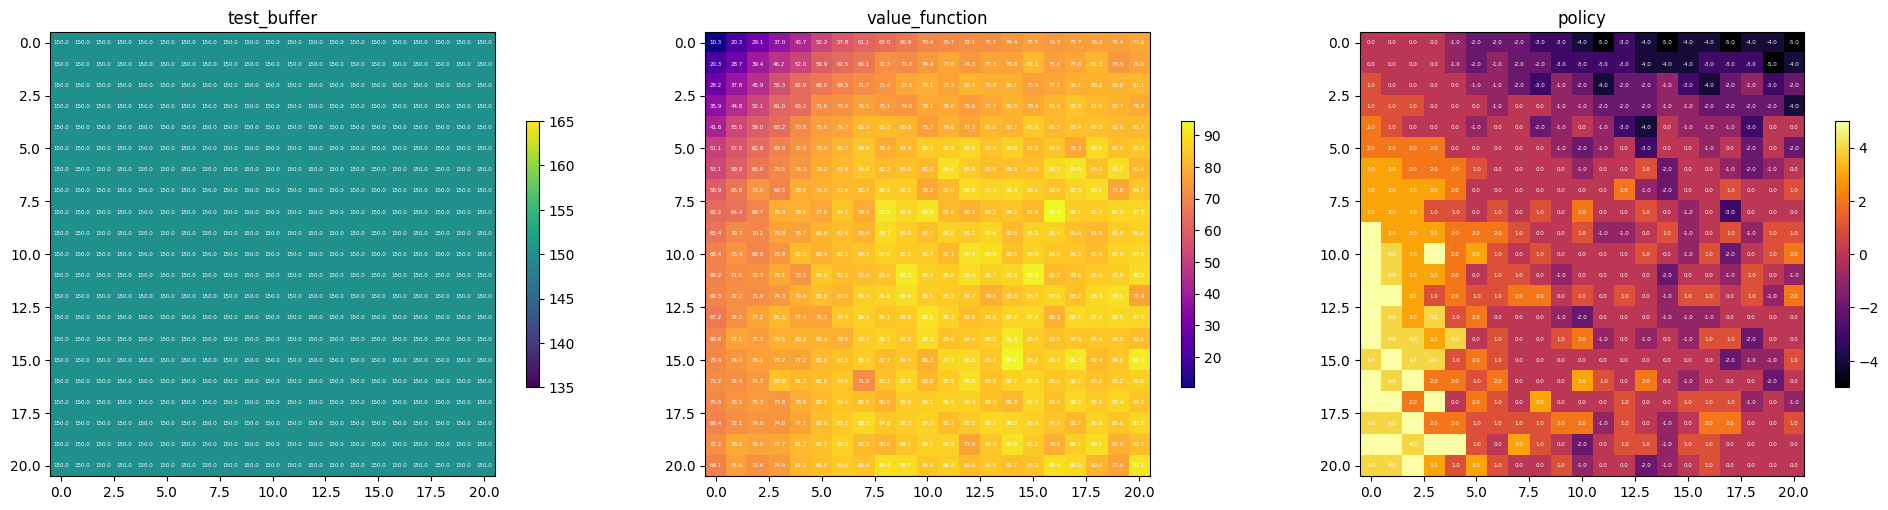

In [10]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # Adjust the number of subplots and figure size

def display_values(ax, data, cmap):
    """Utility function to display matrix values."""
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text_val = f"{data[i, j]:.1f}"  # Format to two decimal places
            ax.text(j, i, text_val, ha='center', va='center', color='w', fontsize=4)  # 'w' means white color and fontsize set to 6

# Plotting test_buffer with the 'viridis' colormap and adding a colorbar
im0 = axes[0].imshow(test_buffer, cmap='viridis')
axes[0].set_title("test_buffer")
fig.colorbar(im0, ax=axes[0], shrink=0.6)
display_values(axes[0], test_buffer, 'viridis')

# Plotting value_function with the 'plasma' colormap and adding a colorbar
im1 = axes[1].imshow(value_function, cmap='plasma')
axes[1].set_title("value_function")
fig.colorbar(im1, ax=axes[1], shrink=0.6)
display_values(axes[1], value_function, 'plasma')

# Plotting policy with the 'inferno' colormap and adding a colorbar
im2 = axes[2].imshow(policy, cmap='inferno')
axes[2].set_title("policy")
fig.colorbar(im2, ax=axes[2], shrink=0.6)
display_values(axes[2], policy, 'inferno')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


#run the policy on an example

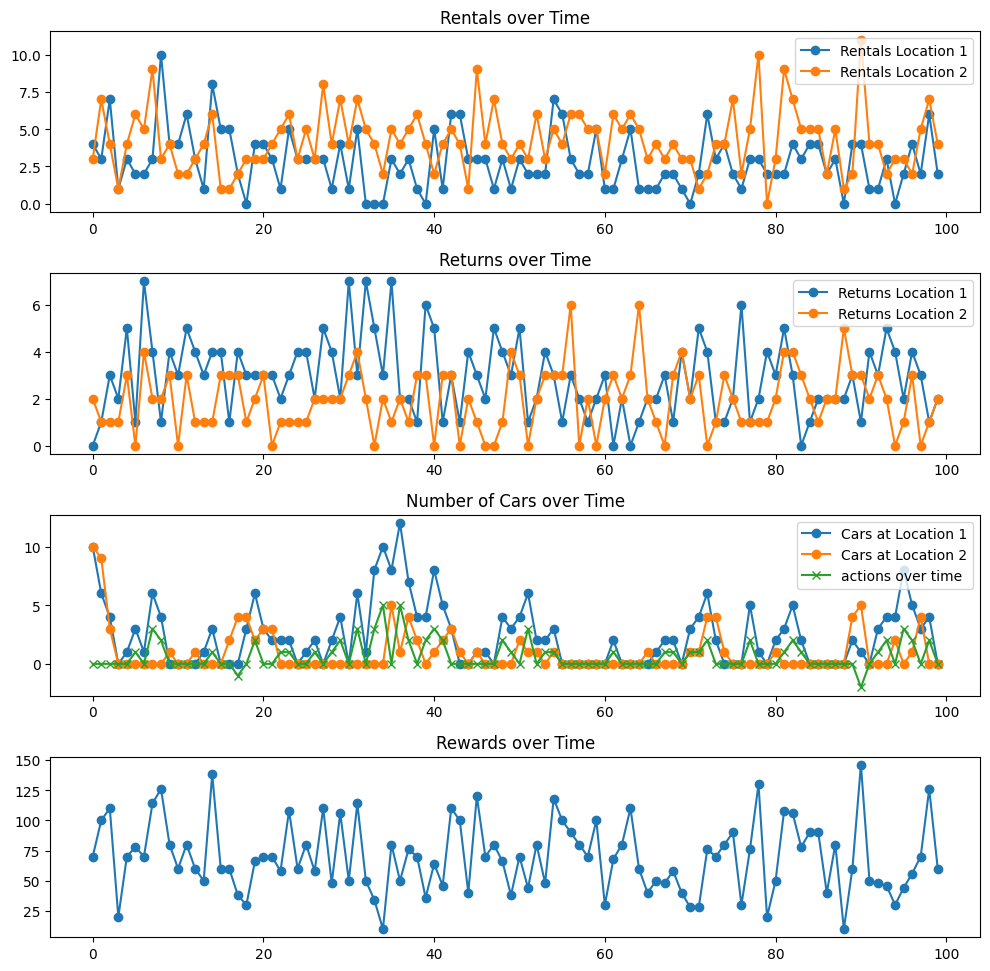

Final state after 20 steps: (0, 0)


In [9]:
def generate_trajectory(initial_state, policy, steps=10):
    states = []
    rewards = []
    rents_loc1_list = []
    rents_loc2_list = []
    returns_loc1_list = []
    returns_loc2_list = []
    actions_list = []

    state = initial_state
    for step in range(steps):
        # Collect states
        states.append(state)

        # Action based on policy
        action = policy[state[0]][state[1]]
        actions_list.append(action)

        # Rentals and returns
        rents_loc1 = poisson.rvs(LAMBDA_REQUEST_1)
        rents_loc2 = poisson.rvs(LAMBDA_REQUEST_2)
        returns_loc1 = poisson.rvs(LAMBDA_RETURN_1)
        returns_loc2 = poisson.rvs(LAMBDA_RETURN_2)

        # Collect data for plotting
        rents_loc1_list.append(rents_loc1)
        rents_loc2_list.append(rents_loc2)
        returns_loc1_list.append(returns_loc1)
        returns_loc2_list.append(returns_loc2)

        reward = RENT_REWARD * (rents_loc1 + rents_loc2) - MOVE_COST * abs(action)
        rewards.append(reward)

        # Update state based on dynamics
        cars_loc1 = min(MAX_CARS, max(0, state[0] - rents_loc1 + returns_loc1 - action))
        cars_loc2 = min(MAX_CARS, max(0, state[1] - rents_loc2 + returns_loc2 + action))
        state = (cars_loc1, cars_loc2)

    # Plot data
    plt.figure(figsize=(10, 12))

    plt.subplot(5, 1, 1)
    plt.plot(range(steps), rents_loc1_list, '-o', label="Rentals Location 1")
    plt.plot(range(steps), rents_loc2_list, '-o', label="Rentals Location 2")
    plt.legend()
    plt.title('Rentals over Time')

    plt.subplot(5, 1, 2)
    plt.plot(range(steps), returns_loc1_list, '-o', label="Returns Location 1")
    plt.plot(range(steps), returns_loc2_list, '-o', label="Returns Location 2")
    plt.legend()
    plt.title('Returns over Time')

    plt.subplot(5, 1, 3)
    plt.plot(range(steps), [s[0] for s in states], '-o', label="Cars at Location 1")
    plt.plot(range(steps), [s[1] for s in states], '-o', label="Cars at Location 2")
    plt.plot(range(steps), actions_list, '-x', label="actions over time")
    plt.legend()
    plt.title('Number of Cars over Time')

    plt.subplot(5, 1, 4)
    plt.plot(range(steps), rewards, '-o')
    plt.title('Rewards over Time')

    plt.tight_layout()
    plt.show()

    return state

# Example
final_state = generate_trajectory((10, 10), policy, steps=100)
print(f"Final state after 20 steps: {final_state}")
